# Automated detection of symmetry-protected subspaes in quantum simulations
In this notebook, we give a tutorial on how to use our code to identify the symmetry-protected subspaces of the Heisenberg-XXX model, and how to identify errors with it. This work pairs with the technical article https://arxiv.org/abs/2302.08586 by the same authors; this is the manuscript mentioned throughout the tutorial.

In [1]:
import json

import circuits_warehouse as cw
import sps_detection as sps

%load_ext autoreload
%autoreload 2

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    import cirq
    print("installed cirq.")
    
try:
    import matplotlib.pyplot as plt
except ImportError:
    print("installing matplotlib...")
    !pip install --quiet matplotlib
    import matplotlib.pyplot as plt
    print("installed matplotlib.")
    
try:
    import numpy as np
except ImportError:
    print("installing numpy...")
    !pip install --quiet numpy
    import numpy as np
    print("installed numpy.")

## Forming a set of substring edit maps
We want to simulate the Heisenberg-XXX model: 
$$H= \sum_{i=0}^{n-2}\Big[ X_iX_{i+1} + Y_{i}Y_{i+1} + Z_iZ_{i+1}\Big] + X_0X_{n-1} + Y_{0}Y_{n-1} + Z_0Z_{n-1}$$
which has symmetries 
$$S^z= \sum_i Z_i,\;S^x= \sum_i X_i,\;S^y= \sum_i Y_i$$
To simplify, we will only simulate $n=6$ and Trotterize (shown below). Additionally, we only measure parallel readout in the $Z$ basis, which can reconstruct the $\langle ZZ\rangle$ expectation value of the Heisenberg.

In [3]:
def make_Heisenberg_layer(qubits, n, exponent):
    # make one trotter layer
    circuit = []
    ops = []
    # even layer
    for i in range(0,n-1,2):
        zz = cirq.ZZ(qubits[i], qubits[i+1])**exponent
        iswap = cirq.ISWAP(qubits[i], qubits[i+1])**exponent
        # build the circuit
        circuit.append(zz)
        circuit.append(iswap)
        # set aside for the substring edit maps
        ops.append( [cirq.unitary(iswap),(i,i+1) ])
    # odd layer   
    for i in range(1,n,2):
        zz = cirq.ZZ(qubits[i], qubits[(i+1)%n])**exponent
        iswap = cirq.ISWAP(qubits[i], qubits[(i+1)%n])**exponent
        # build the circuit
        circuit.append(zz)
        circuit.append(iswap)
        # set aside for the substring edit maps, only need iswap because zz will not change z basis vectors
        ops.append( [cirq.unitary(iswap),(i,(i+1)%n) ])
     
    circuit = cirq.Circuit(circuit)
    return circuit, ops

In [4]:
n = 6
circuit_layer, operators_layer = make_Heisenberg_layer(cirq.LineQubit.range(n), n, .05)
circuit_layer

┌──────────────┐   ┌────────────────────┐
0: ───ZZ────────iSwap────────────────ZZ────────────────────iSwap─────────
      │         │                    │                     │
1: ───ZZ^0.05───iSwap^0.05────ZZ─────┼───────────iSwap─────┼─────────────
                              │      │           │         │
2: ───ZZ────────iSwap─────────ZZ^0.05┼───────────iSwap^0.05┼─────────────
      │         │                    │                     │
3: ───ZZ^0.05───iSwap^0.05────ZZ─────┼───────────iSwap─────┼─────────────
                              │      │           │         │
4: ───ZZ────────iSwap─────────ZZ^0.05┼───────────iSwap^0.05┼─────────────
      │         │                    │                     │
5: ───ZZ^0.05───iSwap^0.05───────────ZZ^0.05───────────────iSwap^0.05────
                             └──────────────┘   └────────────────────┘

Next, we want the set 
$$\mathbb{L} = \{\mathcal{L}_{H_i} \: : \: i=0,1,\dots,n-1\}$$
which we can compute by looking at the local operators $ZZ$ and iSWAP.

The object `QuantumSystem` in our `sps_detection.py` package will host the set of substring edit maps, and the object `StringEditMap` will host the individual substring edit map for a $k$-local operator. 

In [5]:
heis_system = sps.QuantumSystem(
    [sps.StringEditMap(op[0], op[1]) for op in operators_layer]
)
heis_system

Quantum System has substring edit maps:
StringEditOperator: qubits=(0, 1), subspaces={('01', '10'), ('00',), ('11',)}
StringEditOperator: qubits=(2, 3), subspaces={('01', '10'), ('00',), ('11',)}
StringEditOperator: qubits=(4, 5), subspaces={('01', '10'), ('00',), ('11',)}
StringEditOperator: qubits=(1, 2), subspaces={('01', '10'), ('00',), ('11',)}
StringEditOperator: qubits=(3, 4), subspaces={('01', '10'), ('00',), ('11',)}
StringEditOperator: qubits=(5, 0), subspaces={('01', '10'), ('00',), ('11',)}

It may be convenient to get *every* symmetry-protected subspace of the simulation. To do so, use the member function `hilbert_space_closure`, as shown below. Note that each sub-list is grouped by total number of 1's, i.e. total $Z$ spin is conserved within the group.

In [6]:
sps_structure = heis_system.hilbert_space_closure(n)
sps_structure

[{'000000'},
 {'000001', '000010', '000100', '001000', '010000', '100000'},
 {'000011',
  '000101',
  '000110',
  '001001',
  '001010',
  '001100',
  '010001',
  '010010',
  '010100',
  '011000',
  '100001',
  '100010',
  '100100',
  '101000',
  '110000'},
 {'000111',
  '001011',
  '001101',
  '001110',
  '010011',
  '010101',
  '010110',
  '011001',
  '011010',
  '011100',
  '100011',
  '100101',
  '100110',
  '101001',
  '101010',
  '101100',
  '110001',
  '110010',
  '110100',
  '111000'},
 {'001111',
  '010111',
  '011011',
  '011101',
  '011110',
  '100111',
  '101011',
  '101101',
  '101110',
  '110011',
  '110101',
  '110110',
  '111001',
  '111010',
  '111100'},
 {'011111', '101111', '110111', '111011', '111101', '111110'},
 {'111111'}]

## Symmetry-protected subspace with Alg. IV.I
To get the initial state's symmetry-protected subspace, we use the transitive closure of the set of substring edit maps on the initial state: 
$$\mathbb{L}^*(|\psi_0\rangle) = G_{|\psi_0\rangle}$$
which gives every state which a series of substring edit maps connects it to the initial state. If a state is *not* in this set $G_{|\psi_0\rangle}$, there is no way that it can be measured in a time evolution. This is Algorithm IV.I in our manuscript.

We want to simulate the antiferromagnetic state $|\psi_0\rangle=|0101\dots\rangle$ in time. On 6 spin-1/2 particles, we expect 3 spins in $|1\rangle$ and 3 in $|0\rangle$ for each state measured in the $Z$ basis. To compute this set with our algorithm, we do the following

In [7]:
initial_bitstring = '010101'
G = heis_system.transitive_closure(initial_bitstring)
G

{'000111',
 '001011',
 '001101',
 '001110',
 '010011',
 '010101',
 '010110',
 '011001',
 '011010',
 '011100',
 '100011',
 '100101',
 '100110',
 '101001',
 '101010',
 '101100',
 '110001',
 '110010',
 '110100',
 '111000'}

## Shared symmetry-protected subspace with Alg. V.I
Suppose the previous algorithm is intractable to compute. To post-select using the symmetry-protected subspace, we instead use the following procedure. Given an initial state $|\psi_0\rangle$ and a measured state $|b_f\rangle$, we verify if they share a symmetry-protected subspace by attempting to find an element reachable from both $|\psi_0\rangle$ and $|b_f\rangle$ with substring edit maps.

To acheive this *without* constructing an entire symmetry-protected subspace, we attempt to find the state with the smallest bitstring in the symmetry-protected subspace of both $|\psi_0\rangle$ and $|b_f\rangle$. If each state finds the same state, they exist in the same symmetry-protected subspace. 

We show this in the cell below for states which do and do not exist in the symmetry-protected subspace of the initial state. This method uses a heuristic, and therefore can incorrectly assume it has found a SPS's minimal element, when it has not. This heuristic becomes more accurate as `max_depth` increases; for a more detailed conversation, see our manuscript. For the Heiseneberg-XXX model, the heuristic is always correct with `max_depth=1`.

In [8]:
verifier = sps.MeasurementVerifier(heis_system, initial_bitstring)

inside_bitstring = '111000'  # in SPS
outside_bitstring = '100001' # not in SPS

initial_min = verifier.greedy_min_sets_search(initial_bitstring, max_depth=1)
inside_min = verifier.greedy_min_sets_search(inside_bitstring, max_depth=1)
outside_min = verifier.greedy_min_sets_search(outside_bitstring, max_depth=1)

print("{} and {} share a symmetry-protected subspace: {}".format(initial_bitstring, inside_bitstring, initial_min==inside_min))
print("{} and {} share a symmetry-protected subspace: {}".format(initial_bitstring, outside_bitstring, initial_min==outside_min))

010101 and 111000 share a symmetry-protected subspace: True
010101 and 100001 share a symmetry-protected subspace: False


## Post-selection
First, simulate the Heisenberg-XXX model with initial state $|\psi_0\rangle = |010101\rangle$ to establish a baseline. Let's simulate out to 10 discrete time-steps, recall this uses $dt = 0.05$. This tutorial is *not* meant to prove the usefulness of post-selection, just to show how to do it with our software.

In [9]:
qubits = cirq.LineQubit.range(n)
initial_circuit = cirq.Circuit([cirq.X(qubits[i]) for i in [1,3,5]]) # initialize the antiferromagnetic state
nmeas = 10_000

initial_bitstring = '010101'
other_bitstring = '101010'
outside_bitstring = '111111'
t_tot = 49

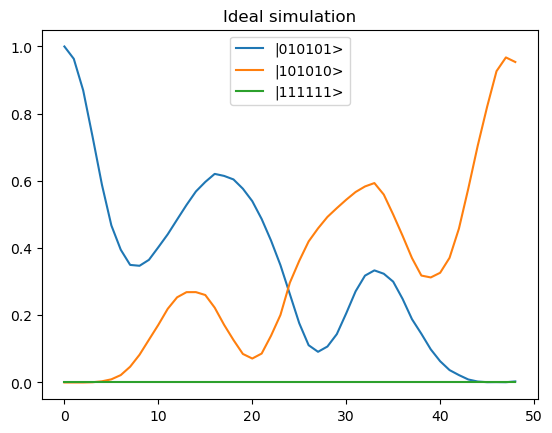

In [10]:
ideal_data_timeseries = {} # store the probability distribution at each time step

# simulate for each time length
for t_cur in range(t_tot):
    circuit = cirq.Circuit(initial_circuit, [circuit_layer for _ in range(t_cur)], cirq.measure(*qubits, key='z'))
    results = cirq.Simulator().run(circuit, repetitions=nmeas).histogram(key='z')
    ideal_data_timeseries[t_cur] = results

plt.title("Ideal simulation")
plt.plot([data[int(initial_bitstring,2)]/nmeas for data in ideal_data_timeseries.values()], label='|{}>'.format(initial_bitstring))
plt.plot([data[int(other_bitstring,2)]/nmeas for data in ideal_data_timeseries.values()], label='|{}>'.format(other_bitstring))
plt.plot([data[int(outside_bitstring,2)]/nmeas for data in ideal_data_timeseries.values()], label='|{}>'.format(outside_bitstring))
plt.legend()

Noisy simulation! We just insert operation $X$ on each qubit with low probability, and simulate to each time.

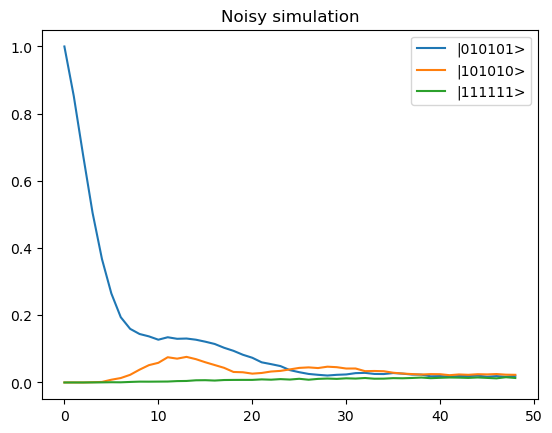

In [11]:
noisy_data_timeseries = {} # store the probability distribution at each time step

# simulate for each time length
for t_cur in range(t_tot):
    circuit = cirq.Circuit(initial_circuit, 
                           [[circuit_layer, [cirq.X(q).with_probability(0.02) for q in qubits]] for _ in range(t_cur)], 
                           cirq.measure(*qubits, key='z'))
    results = cirq.DensityMatrixSimulator().run(circuit, repetitions=nmeas).histogram(key='z')
    noisy_data_timeseries[t_cur] = results

plt.title("Noisy simulation")
plt.plot([data[int(initial_bitstring,2)]/nmeas for data in noisy_data_timeseries.values()], label='|{}>'.format(initial_bitstring))
plt.plot([data[int(other_bitstring,2)]/nmeas for data in noisy_data_timeseries.values()], label='|{}>'.format(other_bitstring))
plt.plot([data[int(outside_bitstring,2)]/nmeas for data in noisy_data_timeseries.values()], label='|{}>'.format(outside_bitstring))
plt.legend()

### Post-selection by inclusion in the symmetry-protected subspace (Alg. IV.I)
First, we will post select by checking if each measured state is in a pre-computed post-selected subspace. This will search for each state within `G` defined earlier.

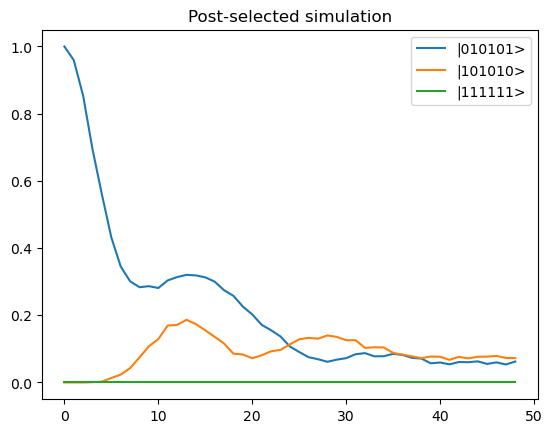

In [12]:
ps_data_timeseries = {}
for t_cur, data in noisy_data_timeseries.items():
    ps_data = {}
    kept_nmeas = 0
    for state_int, num in data.items():
        state_bitstring = ('{0:0'+str(n)+'b}').format(state_int) # cirq gives us integers, convert to bitstring
        if state_bitstring in G: # THIS is the post-selection decision
            ps_data[state_int] = num
            kept_nmeas += num
    ps_data_timeseries[t_cur] = {key: val/kept_nmeas for key,val in ps_data.items()} # renormalize here for PS data

plt.title("Post-selected simulation")
plt.plot([data[int(initial_bitstring,2)] for data in ps_data_timeseries.values()], label='|{}>'.format(initial_bitstring))
plt.plot([data[int(other_bitstring,2)] if int(other_bitstring,2) in data.keys() else 0  for data in ps_data_timeseries.values()], label='|{}>'.format(other_bitstring))
plt.plot([data[int(outside_bitstring,2)]/nmeas if int(outside_bitstring,2) in data.keys() else 0 for data in ps_data_timeseries.values()], label='|{}>'.format(outside_bitstring))
plt.legend()

Now combine the ideal, noisy, and post-selected timeseries of the initial bitstring to see the amplitudes of each.

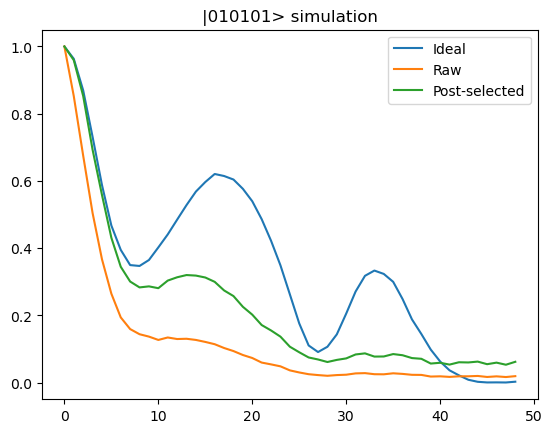

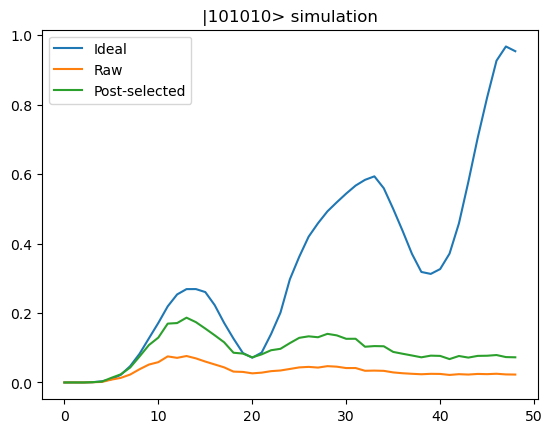

In [13]:
plt.title("|{}> simulation".format(initial_bitstring))
plt.plot([data[int(initial_bitstring,2)]/nmeas for data in ideal_data_timeseries.values()], label='Ideal'.format(initial_bitstring))
plt.plot([data[int(initial_bitstring,2)]/nmeas for data in noisy_data_timeseries.values()], label='Raw'.format(initial_bitstring))
plt.plot([data[int(initial_bitstring,2)] for data in ps_data_timeseries.values()], label='Post-selected'.format(initial_bitstring))
plt.legend()
plt.show()

plt.title("|{}> simulation".format(other_bitstring))
plt.plot([data[int(other_bitstring,2)]/nmeas for data in ideal_data_timeseries.values()], label='Ideal'.format(other_bitstring))
plt.plot([data[int(other_bitstring,2)]/nmeas if int(other_bitstring,2) in data.keys() else 0 for data in noisy_data_timeseries.values()], label='Raw'.format(other_bitstring))
plt.plot([data[int(other_bitstring,2)] if int(other_bitstring,2) in data.keys() else 0  for data in ps_data_timeseries.values()], label='Post-selected'.format(other_bitstring))
plt.legend()
plt.show()

### Post-selection by search collision (Alg. V.I)
This time, we check if each state finds the same minimal element when input to `greedy_min_sets_search` as the initial state, and post-select accordingly.

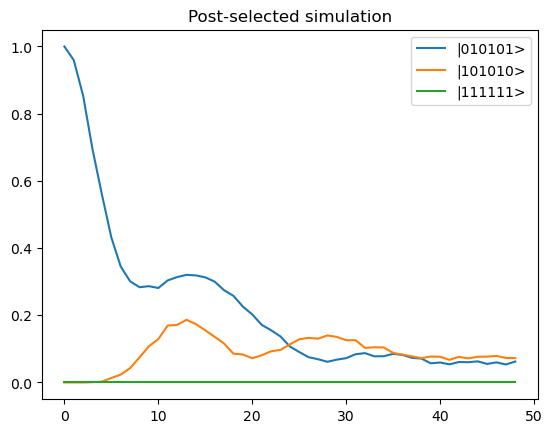

In [14]:
initial_min = verifier.greedy_min_sets_search(initial_bitstring)
ps_data_timeseries = {}

for t_cur, data in noisy_data_timeseries.items():
    ps_data = {}
    kept_nmeas = 0
    for state_int, num in data.items():
        state_bitstring = ('{0:0'+str(n)+'b}').format(state_int) # cirq gives us integers, convert to bitstring
        if verifier.greedy_min_sets_search(state_bitstring) == initial_min: # THIS is the post-selection decision 
            ps_data[state_int] = num
            kept_nmeas += num
    ps_data_timeseries[t_cur] = {key: val/kept_nmeas for key,val in ps_data.items()}

plt.title("Post-selected simulation")
plt.plot([data[int(initial_bitstring,2)] for data in ps_data_timeseries.values()], label='|{}>'.format(initial_bitstring))
plt.plot([data[int(other_bitstring,2)] if int(other_bitstring,2) in data.keys() else 0  for data in ps_data_timeseries.values()], label='|{}>'.format(other_bitstring))
plt.plot([data[int(outside_bitstring,2)]/nmeas if int(outside_bitstring,2) in data.keys() else 0 for data in ps_data_timeseries.values()], label='|{}>'.format(outside_bitstring))
plt.legend()

Now combine the ideal, noisy, and post-selected timeseries of the initial bitstring to see the amplitudes of each.

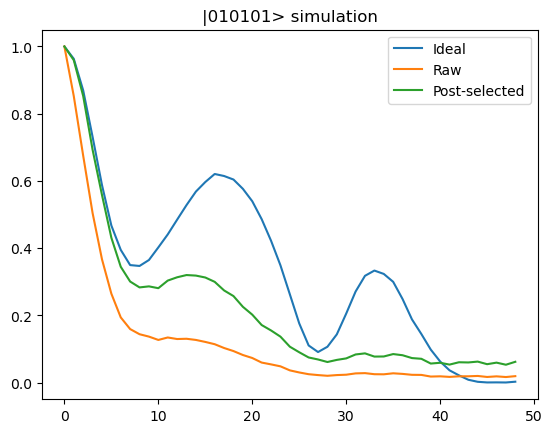

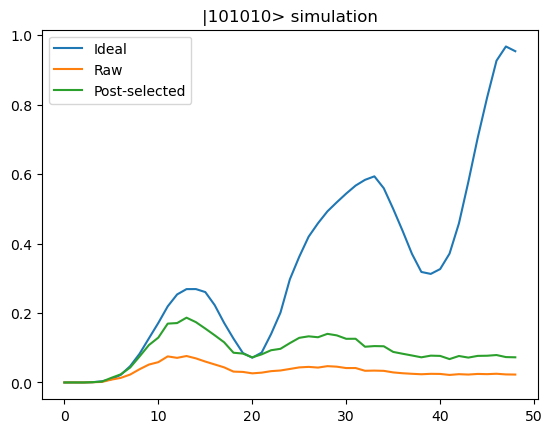

In [15]:
plt.title("|{}> simulation".format(initial_bitstring))
plt.plot([data[int(initial_bitstring,2)]/nmeas for data in ideal_data_timeseries.values()], label='Ideal'.format(initial_bitstring))
plt.plot([data[int(initial_bitstring,2)]/nmeas for data in noisy_data_timeseries.values()], label='Raw'.format(initial_bitstring))
plt.plot([data[int(initial_bitstring,2)] for data in ps_data_timeseries.values()], label='Post-selected'.format(initial_bitstring))
plt.legend()
plt.show()

plt.title("|{}> simulation".format(other_bitstring))
plt.plot([data[int(other_bitstring,2)]/nmeas for data in ideal_data_timeseries.values()], label='Ideal'.format(other_bitstring))
plt.plot([data[int(other_bitstring,2)]/nmeas if int(other_bitstring,2) in data.keys() else 0 for data in noisy_data_timeseries.values()], label='Raw'.format(other_bitstring))
plt.plot([data[int(other_bitstring,2)] if int(other_bitstring,2) in data.keys() else 0  for data in ps_data_timeseries.values()], label='Post-selected'.format(other_bitstring))
plt.legend()
plt.show()